In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from tqdm import tqdm

# Creating and Training the Model

## The cell below creates classes for reading data from tiff stacks

In [9]:

# Custom Dataset class to handle TIFF stacks
class TiffDataset(Dataset):
    def __init__(self, image_path, mask_path, transform=None):
        self.images = imread(image_path)
        self.masks = imread(mask_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        
        # Convert single-channel image to three channels
        image = np.stack([image] * 3, axis=-1)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        # Ensure the mask is a single channel
        mask = mask[0, :, :].unsqueeze(0)
        
        return image, mask

# Define the U-Net model with ResNet18 backbone
class UNetResNet18(nn.Module):
    def __init__(self, n_classes):
        super(UNetResNet18, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.encoder1 = nn.Sequential(*self.base_layers[:3])
        self.encoder2 = nn.Sequential(*self.base_layers[3:5])
        self.encoder3 = self.base_layers[5]
        self.encoder4 = self.base_layers[6]
        self.encoder5 = self.base_layers[7]

        self.center = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.decoder5 = self._decoder_block(512 + 512, 512)
        self.decoder4 = self._decoder_block(512 + 256, 256)
        self.decoder3 = self._decoder_block(256 + 128, 128)
        self.decoder2 = self._decoder_block(128 + 64, 64)
        self.decoder1 = self._decoder_block(64 + 64, 64)

        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def _decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        enc5 = self.encoder5(enc4)

        center = self.center(enc5)

        dec5 = self.decoder5(torch.cat([center, self._crop(enc5, center)], 1))
        dec4 = self.decoder4(torch.cat([dec5, self._crop(enc4, dec5)], 1))
        dec3 = self.decoder3(torch.cat([dec4, self._crop(enc3, dec4)], 1))
        dec2 = self.decoder2(torch.cat([dec3, self._crop(enc2, dec3)], 1))
        dec1 = self.decoder1(torch.cat([dec2, self._crop(enc1, dec2)], 1))

        final = self.final_conv(dec1)
        return self._resize(final, x.size()[2:])

    def _crop(self, enc, dec):
        _, _, H, W = dec.size()
        enc = transforms.CenterCrop([H, W])(enc)
        return enc

    def _resize(self, input, size):
        return nn.functional.interpolate(input, size=size, mode='bilinear', align_corners=True)

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.HorizontalFlip(p=0.5),
    transforms.Resize((768, 768))  # Ensure the size is a multiple of 32
])




AttributeError: module 'torchvision.transforms' has no attribute 'HorizontalFlip'

## Load data and performs traning

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
# Load dataset
dataset = TiffDataset('./data/training-2-images.tif', './data/training-2-masks.tif', transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = UNetResNet18(n_classes=1).to(device)  # Move model to GPU if available
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(dataloader):
        images, masks = images.to(device), masks.to(device)  # Move data to GPU if available

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader)}')


c:\Users\fultonsaj\AppData\Local\anaconda3\envs\gpu-testing\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\fultonsaj\AppData\Local\anaconda3\envs\gpu-testing\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/250 [00:00<?, ?it/s]c:\Users\fultonsaj\AppData\Local\anaconda3\envs\gpu-testing\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change fr

KeyboardInterrupt: 

## Visualings Training Results

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'unet-710_resnet18.pth')

# Visualize some predictions
model.eval()
with torch.no_grad():
    for i in range(20):
        image, mask = dataset[40*i]
        image = image.unsqueeze(0).to(device)  # Move data to GPU if available
        output = model(image)
        output = torch.sigmoid(output).cpu().squeeze().numpy()

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(image.cpu().squeeze().permute(1, 2, 0).numpy(), cmap='gray')
        axes[0].set_title('Input Image')
        axes[1].imshow(mask.cpu().squeeze().numpy(), cmap='gray')
        axes[1].set_title('Ground Truth')
        axes[2].imshow(output, cmap='gray')
        axes[2].set_title('Prediction')
        plt.show()

# Testing the Model on New Data
cells below create custom classes for reading data from a tiif stack and uses the trained model to create prediction masks.

In [26]:

# Custom Dataset class to handle TIFF stacks
class TiffDataset2(Dataset):
    def __init__(self, image_path, mask_path=None, transform=None):
        self.images = imread(image_path)
        self.masks = imread(mask_path) if mask_path else None
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        
        # Convert single-channel image to three channels
        image = np.stack([image] * 3, axis=-1)
        
        # Convert image type to uint8
        image = (image / image.max() * 255).astype(np.uint8)

        if self.transform:
            image = self.transform(image)
        
        if self.masks is not None:
            mask = self.masks[idx]
            mask = self.transform(mask)
            # Ensure the mask is a single channel
            mask = mask[0, :, :].unsqueeze(0)
            return image, mask
        else:
            return image


# Load the new dataset to segment
segment_dataset = TiffDataset2('./data/good-data-to-segment.tif', transform=transform)
segment_dataloader = DataLoader(segment_dataset, batch_size=1, shuffle=False)

# Initialize the model and load the trained weights
model = UNetResNet18(n_classes=1).to(device)  # Move model to GPU if available
model.load_state_dict(torch.load('unet-710_resnet18.pth'))
model.eval()

# Function to save predictions as TIFF stack
def save_predictions_as_tiff(predictions, output_path):
    (output_path, np.array(predictions, dtype=np.uint8))

# Make predictions and save the results
predictions = []
with torch.no_grad():
    for images in tqdm(segment_dataloader):
        images = images.to(device)  # Move data to GPU if available
        outputs = model(images)
        outputs = torch.sigmoid(outputs).cpu().squeeze().numpy()
        predictions.append(outputs)

# Save predictions to a new TIFF file
save_predictions_as_tiff(predictions, './data/segmented_results.tif')




100%|██████████| 70/70 [00:03<00:00, 20.53it/s]


## Plotting Prediction Results

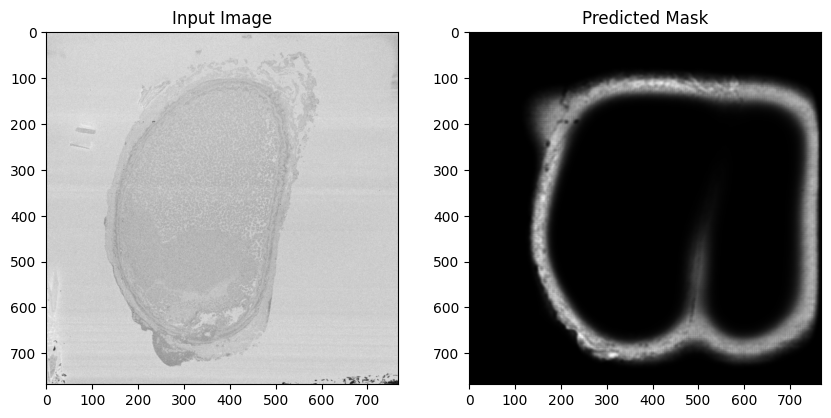

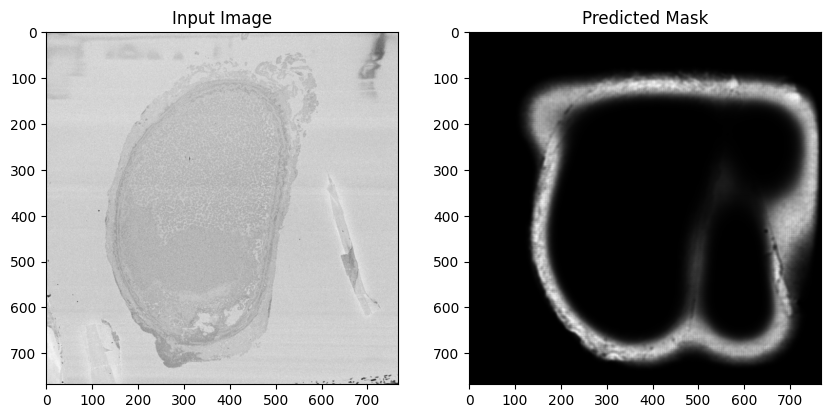

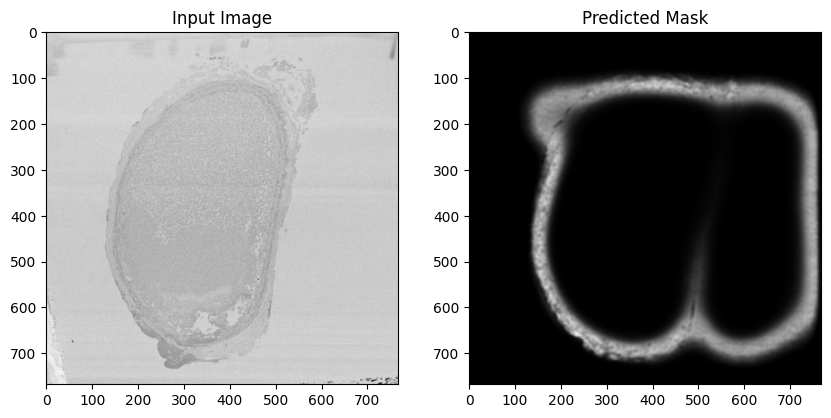

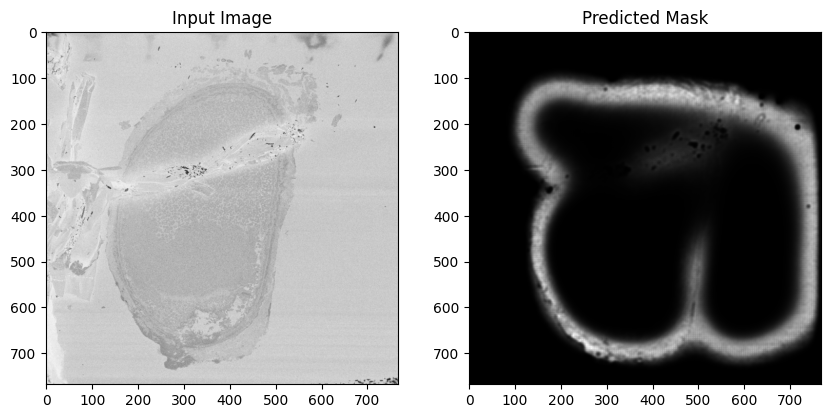

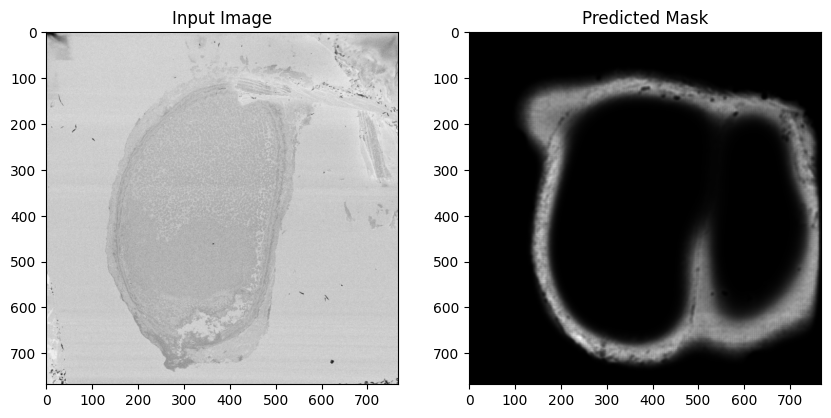

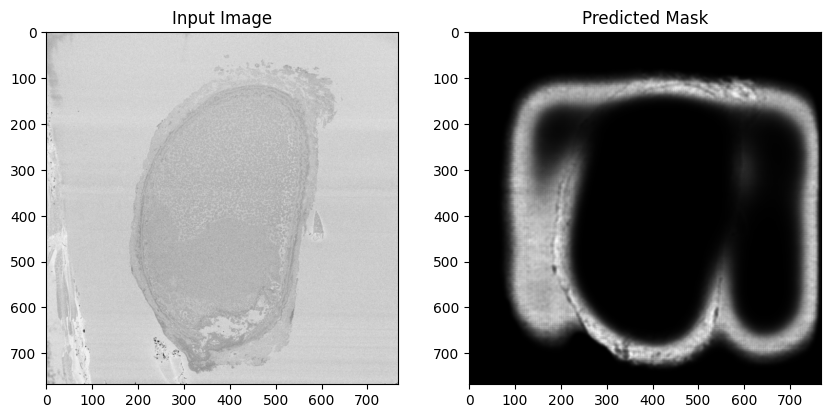

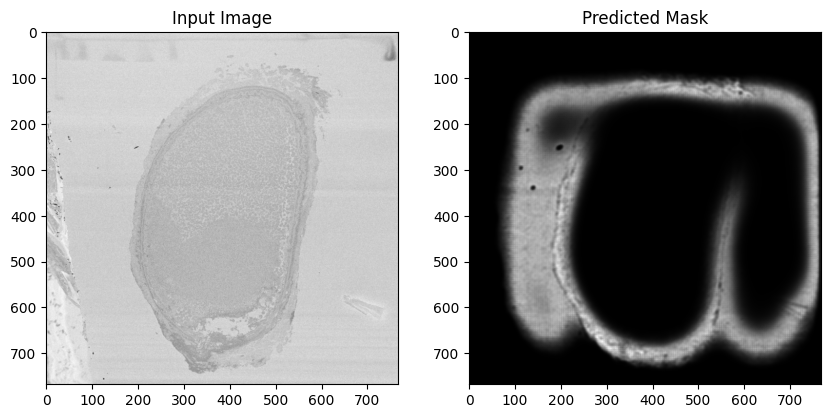

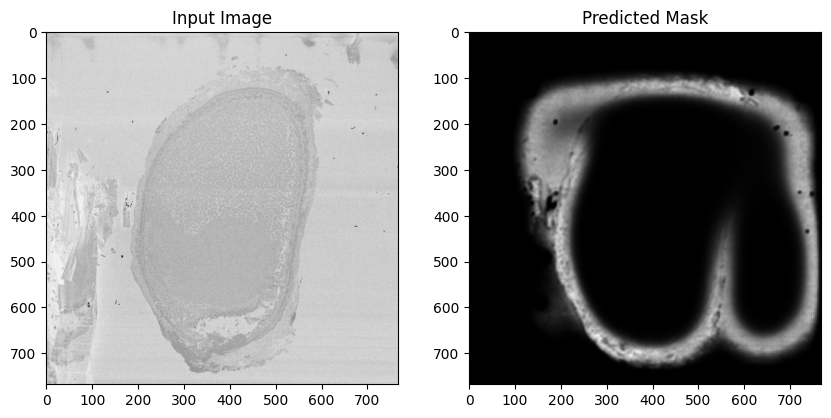

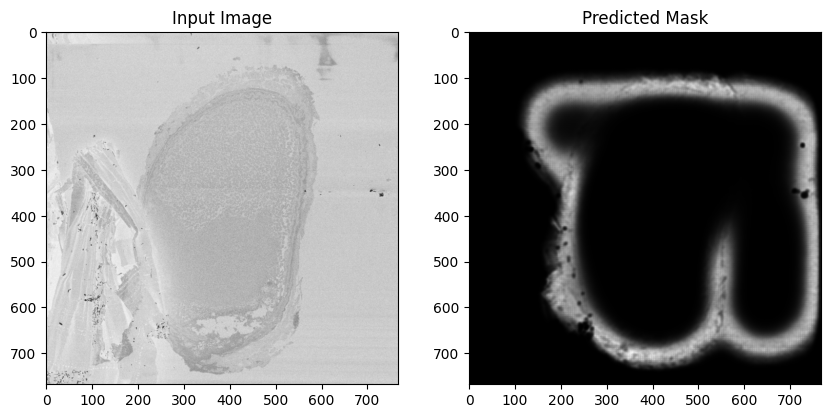

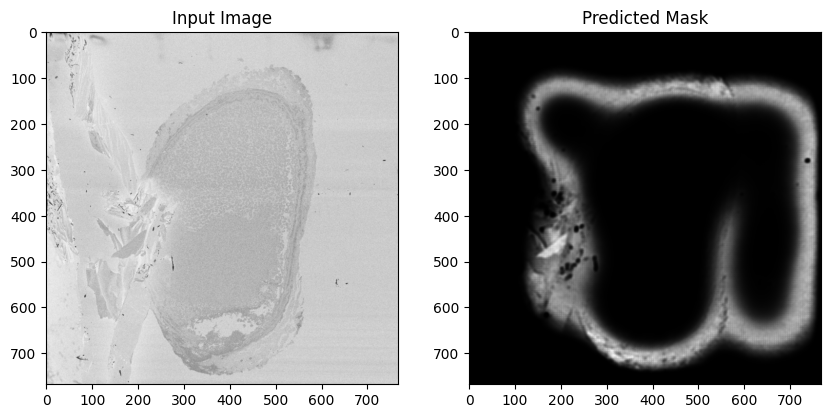

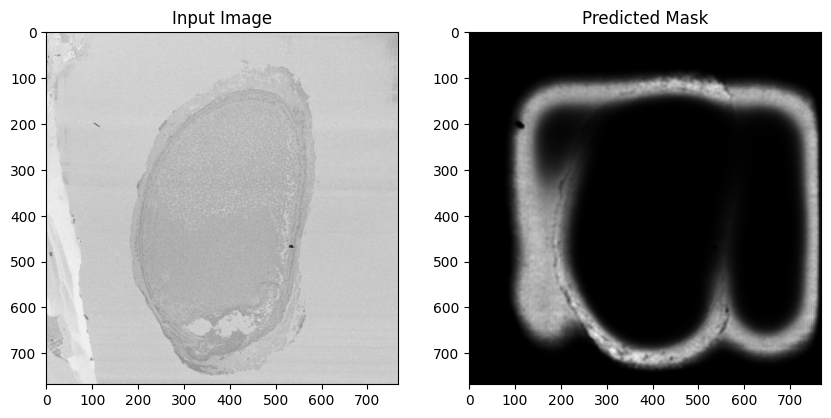

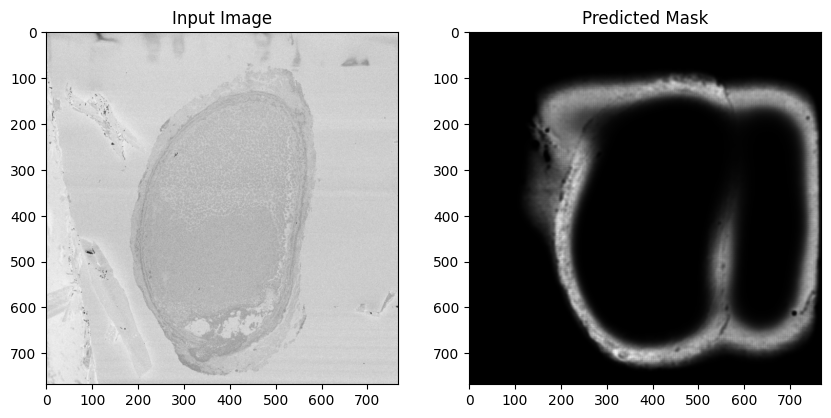

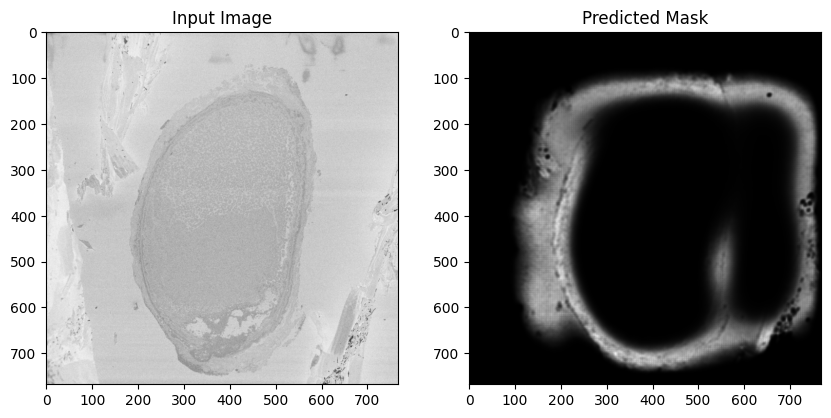

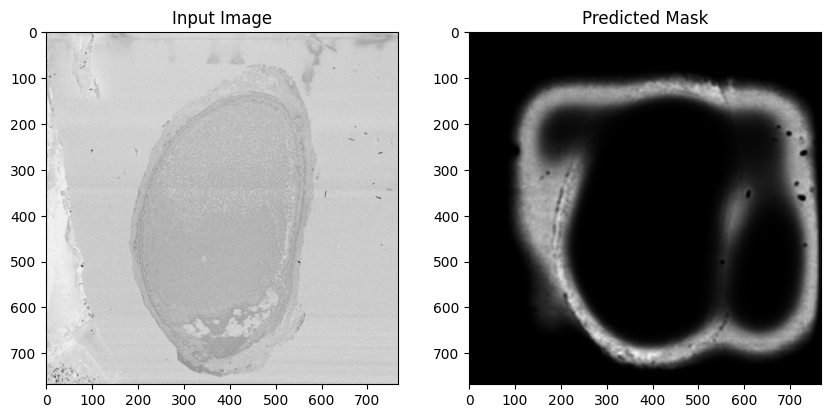

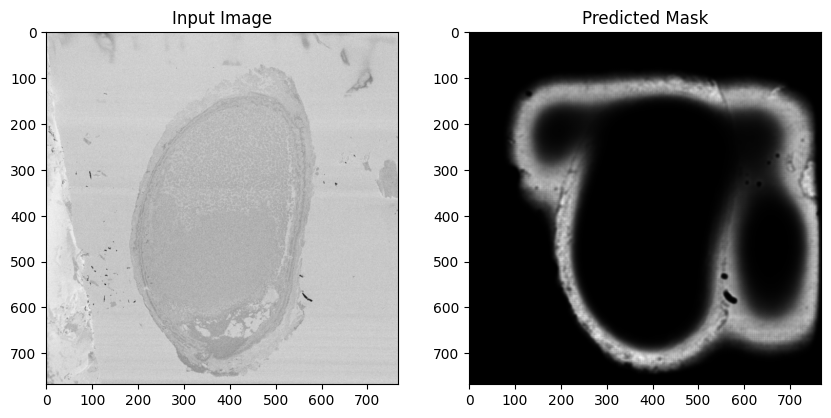

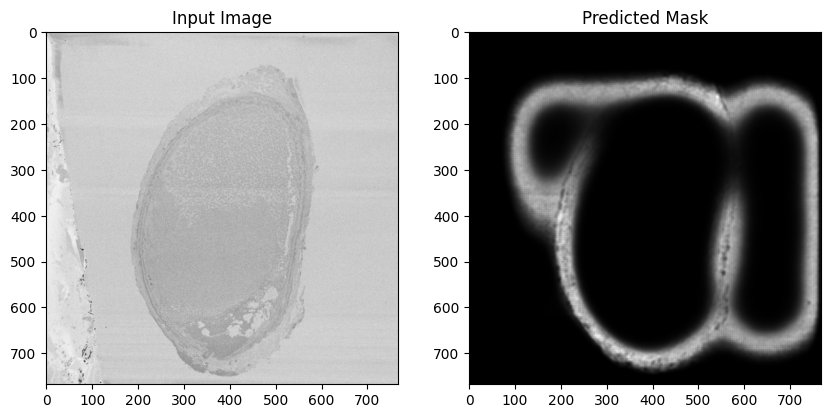

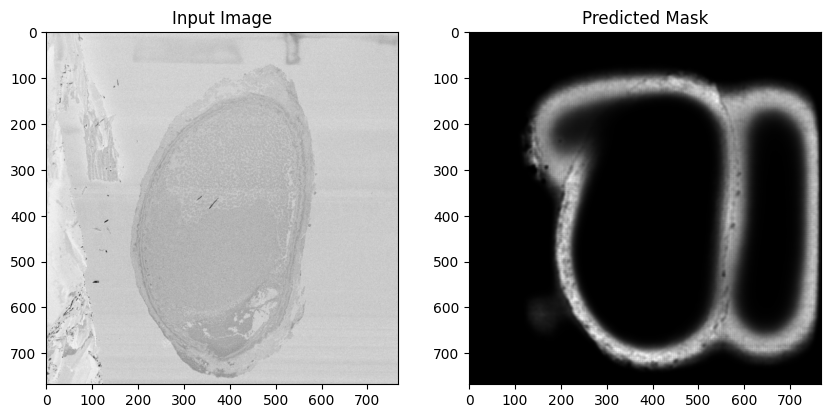

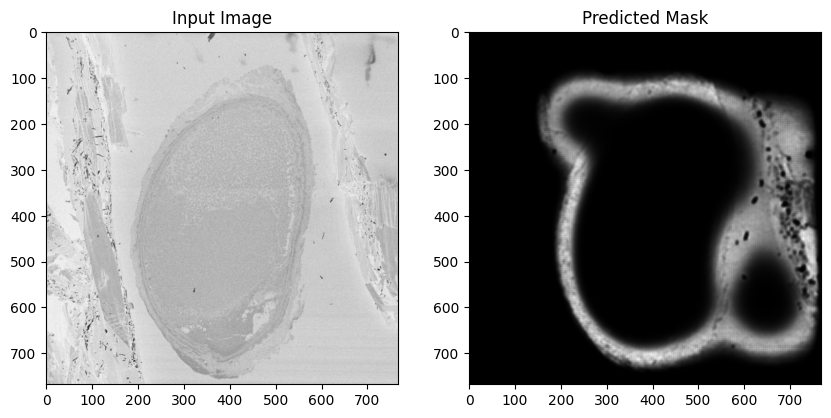

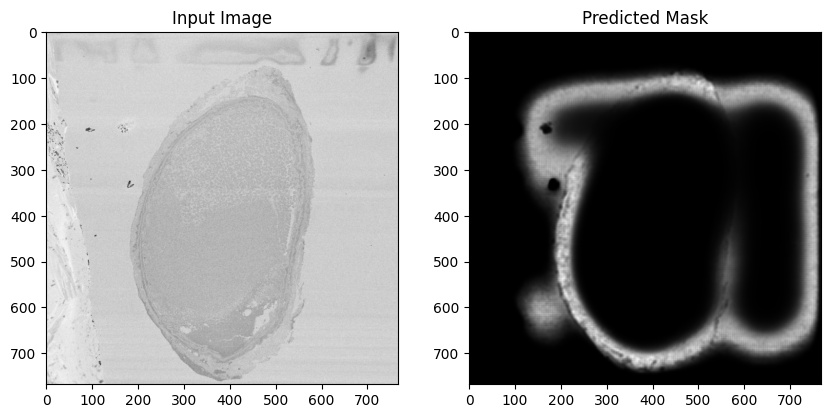

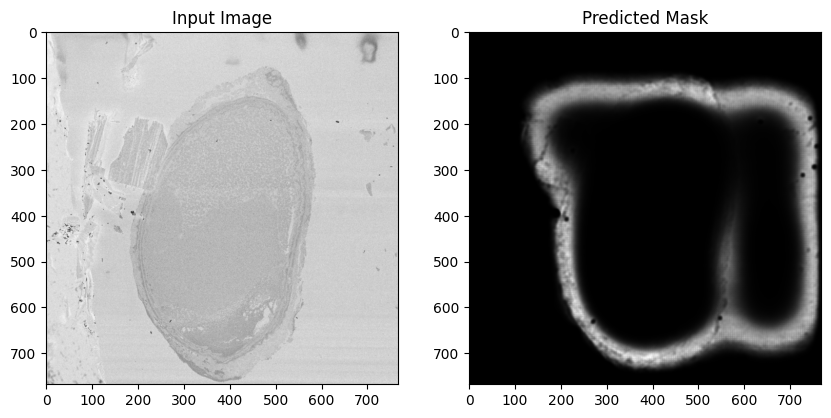

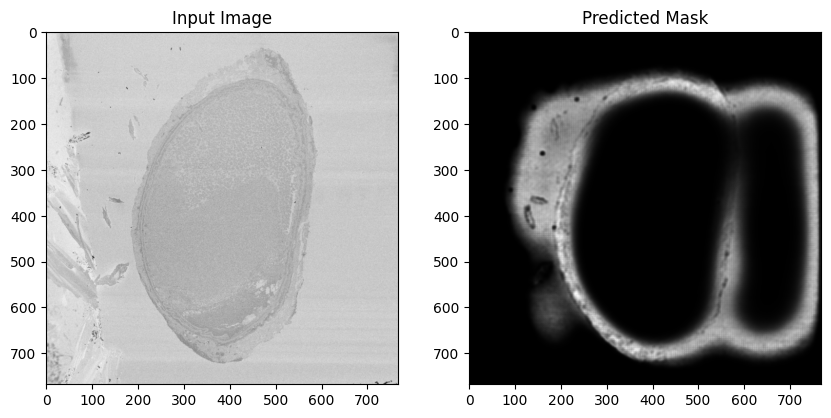

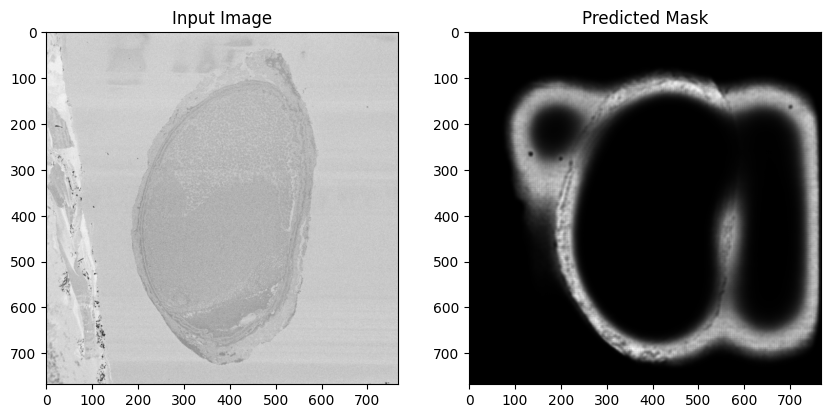

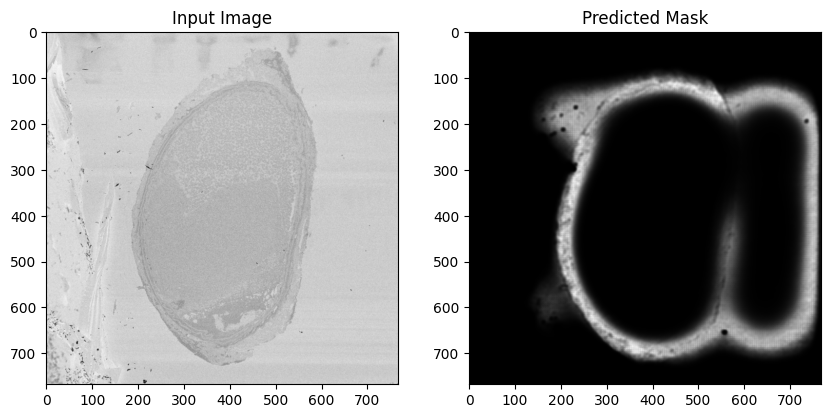

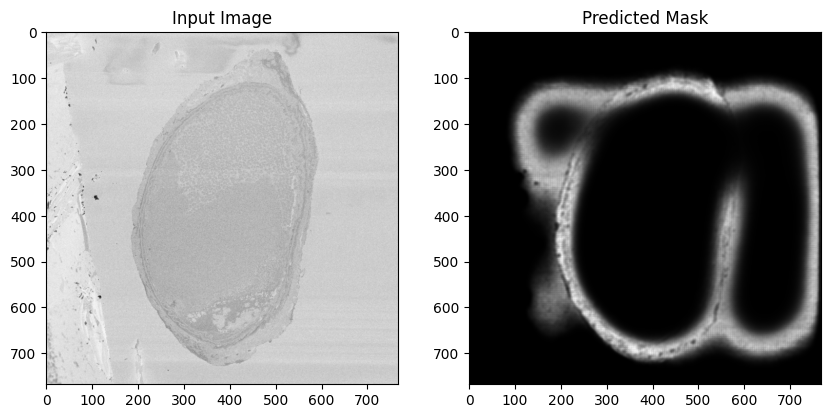

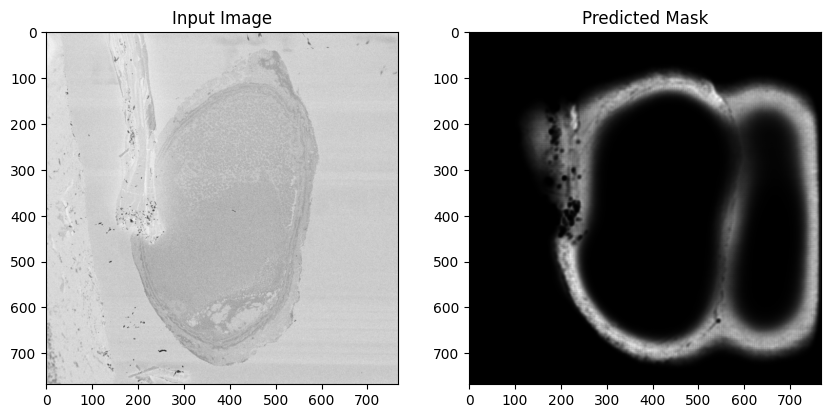

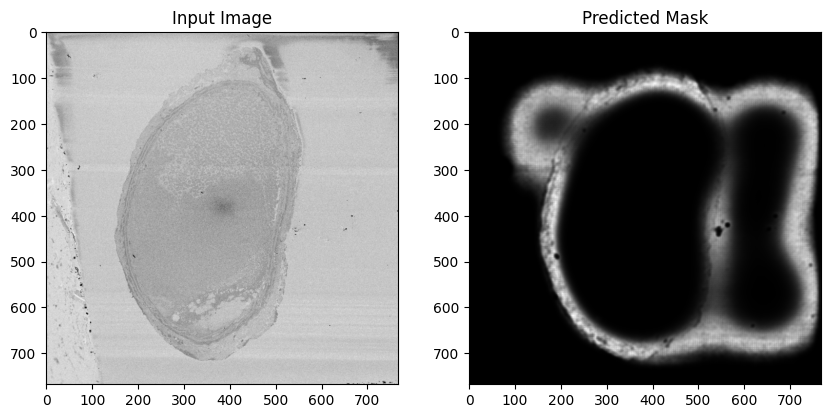

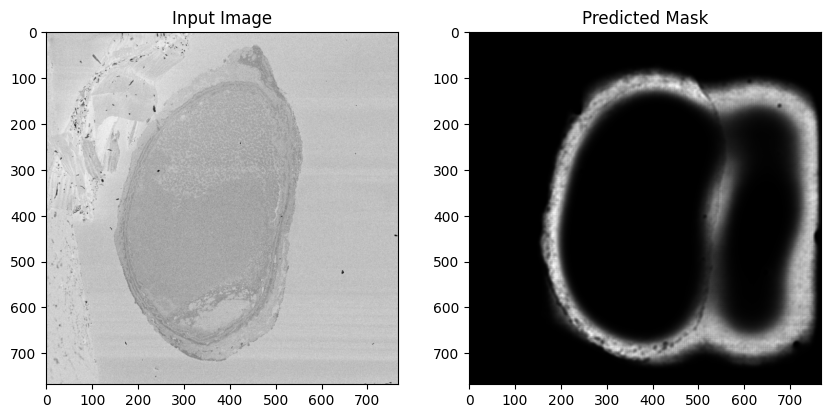

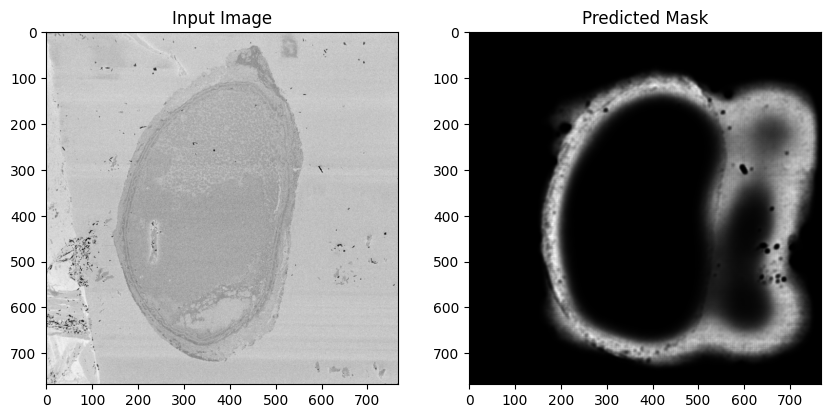

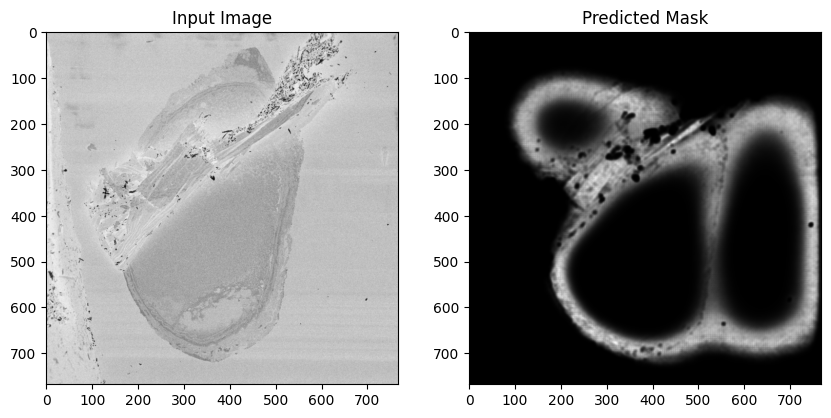

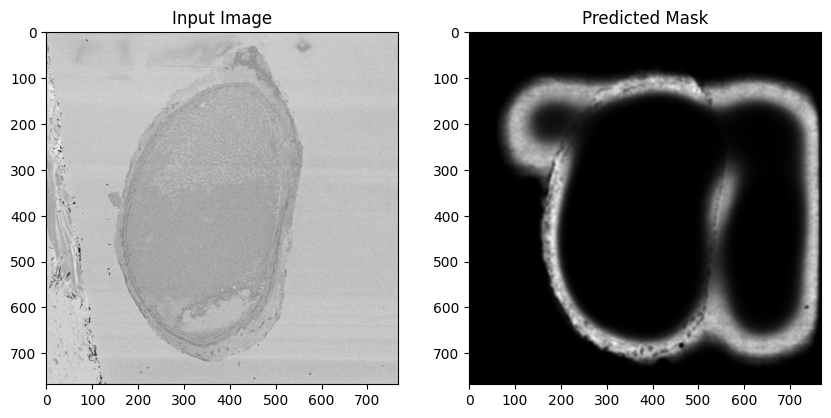

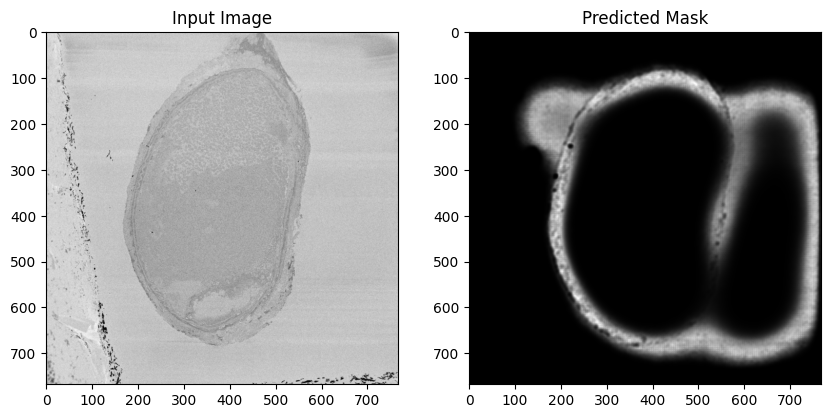

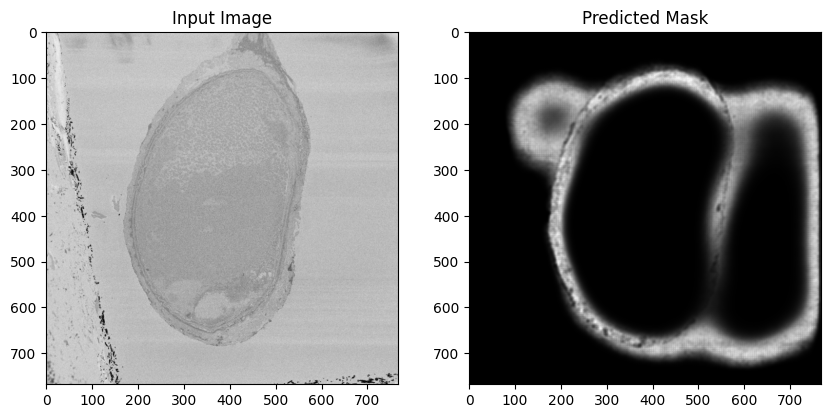

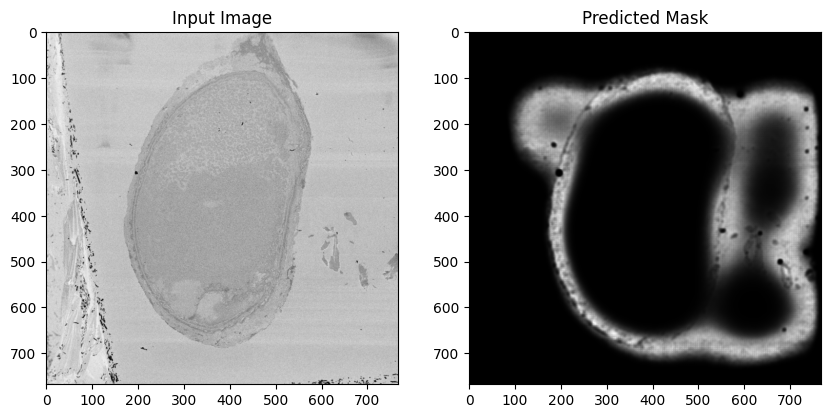

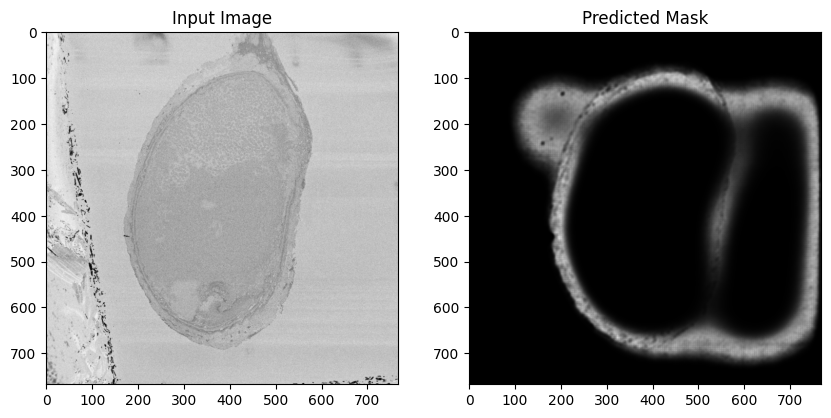

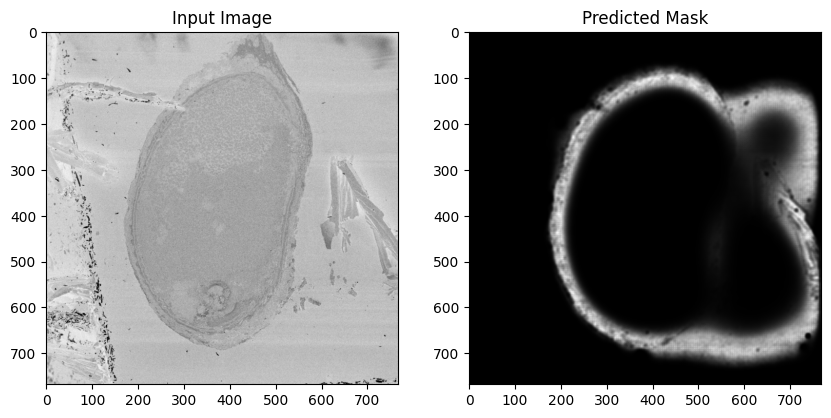

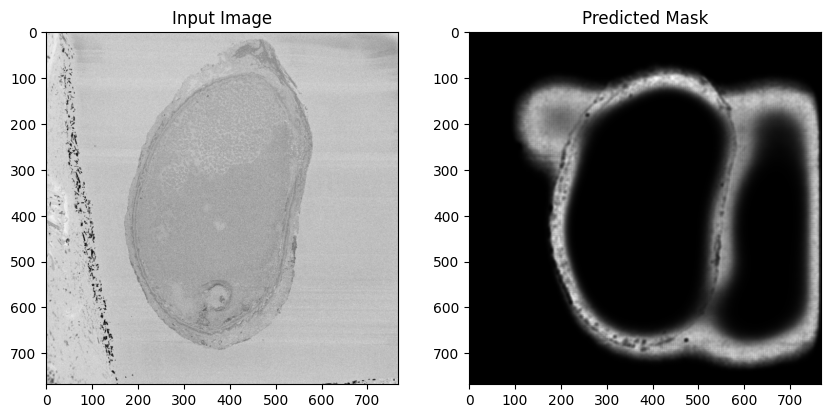

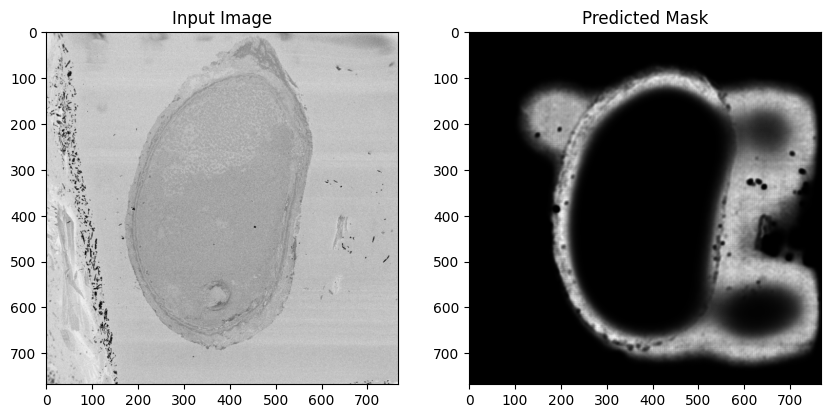

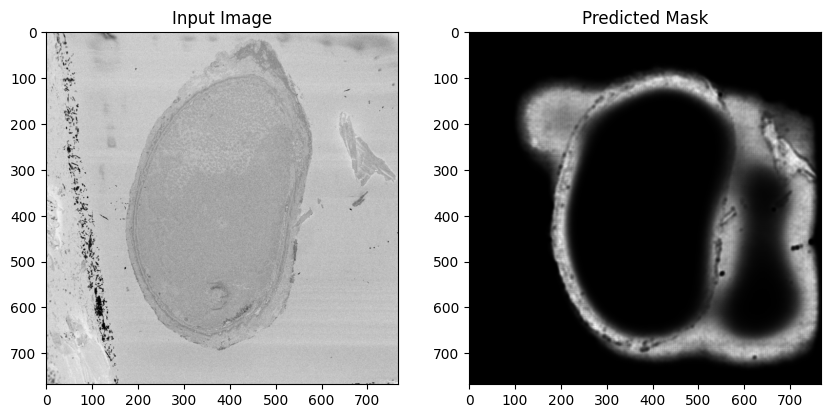

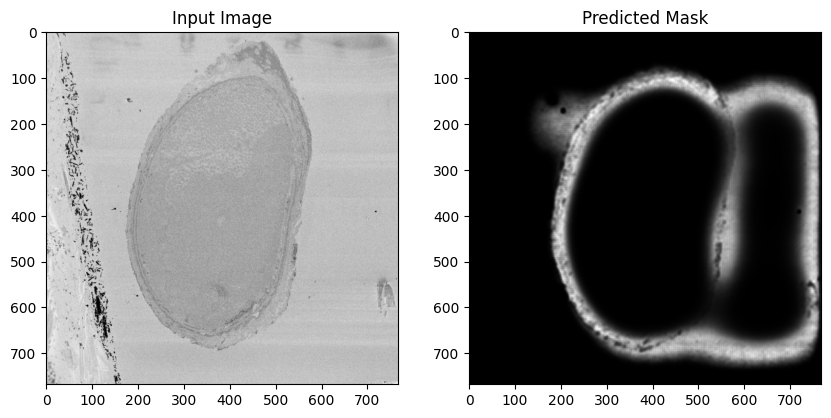

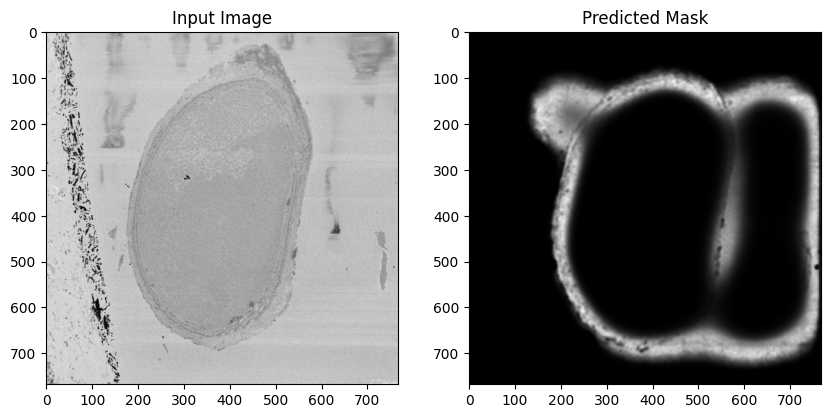

In [27]:
# Optionally, visualize a few results
for i in range(40):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(segment_dataset[i].permute(1, 2, 0).numpy(), cmap='gray')
    axes[0].set_title('Input Image')
    axes[1].imshow(predictions[i], cmap='gray')
    axes[1].set_title('Predicted Mask')
    plt.show()
